In [1]:
from pprint import pprint
from box import Box

config = {
    'debug': False,
    'name': 'Petfinder',
    'seed': 999,
    'n_splits': 10,
    'epochs': 5,
    'root': "../datasets/kaggle/petfinder",
    'image_size_tta': 256,
    'image_size': 224,
    'work_dir': './checkpoint',
    'log_level': 'INFO',
    'log_average_filter':['pred', 'label'],
    'log_config': {
        'interval': 10,
        'hooks' : [
            dict(name='PetfinderLoggerHook'),
            # dict(name='TextLoggerHook'),
        ]
    },
    'model': {
        'name': 'swin_large_patch4_window7_224',
        'output_dim': 1,
    },
    'train_loader': {
        'batch_size': 32,
        'num_workers': 10,
        'shuffle': True,
        'drop_last': True,
        'pin_memory': False,
    },
    'val_loader': {
        'batch_size': 32,
        'num_workers': 10,
        'shuffle': False,
        'drop_last': False,
        'pin_memory': False,
    },
    'optimizer': {
        'name': 'AdamW',
        'lr': 2e-5,
        'betas': (0.9, 0.999),
        'eps': 1e-8,
        'weight_decay': 0.01,
    },
    'optimizer_config': {
        'grad_clip': None
    },
    'lr_config': {
        'policy': 'Step',
        'step': [3, 4],
        'by_epoch': True,
        'warmup': 'linear',
        'warmup_iters': 1,
        'warmup_ratio': 1e-2,
        'warmup_by_epoch': True,
    },
    'workflow': [('train', 1), ('val', 1)],
    'checkpoint_config': {
        'interval': 1,
    },
    'earlystopping_config': {
        'monitor': 'mse',
        'patience': 2,
        'mode': 'min',
    }
}


config = Box(config)
pprint(config)


{'checkpoint_config': <Box: {'interval': 1}>,
 'debug': False,
 'earlystopping_config': {'mode': 'min',
                          'monitor': 'mse',
                          'patience': 2},
 'epochs': 5,
 'image_size': 224,
 'image_size_tta': 256,
 'log_average_filter': <BoxList: ['pred', 'label']>,
 'log_config': {'hooks': <BoxList: [{'name': 'PetfinderLoggerHook'}]>,
                'interval': 10},
 'log_level': 'INFO',
 'lr_config': {'by_epoch': True,
               'policy': 'Step',
               'step': <BoxList: [3, 4]>,
               'warmup': 'linear',
               'warmup_by_epoch': True,
               'warmup_iters': 1,
               'warmup_ratio': 0.01},
 'model': <Box: {'name': 'swin_large_patch4_window7_224', 'output_dim': 1}>,
 'n_splits': 10,
 'name': 'Petfinder',
 'optimizer': {'betas': (0.9, 0.999),
               'eps': 1e-08,
               'lr': 2e-05,
               'name': 'AdamW',
               'weight_decay': 0.01},
 'optimizer_config': <Box: {'grad_cli

In [2]:
from timm import create_model
from fastai.vision.all import *

def set_seed(s, reproducible=False):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    torch.manual_seed(s)
    torch.cuda.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    np.random.seed(s%(2**32-1))
    random.seed(s)
    os.environ['PYTHONHASHSEED'] = str(s)
    if reproducible:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.use_deterministic_algorithms = True

set_seed(config.seed, reproducible=True)
BATCH_SIZE = 32

In [3]:
dataset_path = Path('../datasets/kaggle/petfinder_clean/')
train_df = pd.read_csv(dataset_path/'train.csv')
train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
# train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
train_df['norm_score'] = train_df['Pawpularity']/100

In [4]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#Sturges' rule
num_bins = int(np.floor(1+(3.322)*(np.log2(len(train_df)))))
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)

train_df['fold'] = -1


N_FOLDS = config.n_splits
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=config.seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')


In [5]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

In [6]:
def get_data(fold):
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
                               valid_col='is_valid', #
                               seed=config.seed, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm


class PetfinderModel(nn.Module):
    def __init__(
        self, 
        cfg
    ):
        super(PetfinderModel, self).__init__()
        self._cfg = cfg
        self.backbone = timm.create_model(self._cfg.model.name, pretrained=True, num_classes=self._cfg.model.output_dim)

    def forward(self, x):
        out = self.backbone(x)
        return out

def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = PetfinderModel(config)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.651028,0.647478,18.332195,01:48
1,0.644317,0.640914,17.478945,01:48
2,0.633085,0.641238,17.455807,01:48
3,0.630071,0.640523,17.365005,01:48
4,0.627951,0.640596,17.364141,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.332195281982422.
Better model found at epoch 1 with petfinder_rmse value: 17.478944778442383.
Better model found at epoch 2 with petfinder_rmse value: 17.455806732177734.
Better model found at epoch 3 with petfinder_rmse value: 17.365005493164062.
Better model found at epoch 4 with petfinder_rmse value: 17.3641414642334.
Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653020,0.643761,17.753061,01:48
1,0.642493,0.639817,17.246948,01:49
2,0.634828,0.639209,17.098133,01:55
3,0.632384,0.638342,17.010611,01:50
4,0.629425,0.637764,16.958393,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 17.753061294555664.
Better model found at epoch 1 with petfinder_rmse value: 17.2469482421875.
Better model found at epoch 2 with petfinder_rmse value: 17.098133087158203.
Better model found at epoch 3 with petfinder_rmse value: 17.010610580444336.
Better model found at epoch 4 with petfinder_rmse value: 16.958393096923828.
Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653023,0.644478,17.948023,01:48
1,0.641649,0.643996,17.841522,01:48
2,0.639309,0.639195,17.193279,01:48
3,0.632850,0.639827,17.314318,01:48
4,0.629256,0.639854,17.285421,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 17.948022842407227.
Better model found at epoch 1 with petfinder_rmse value: 17.841522216796875.
Better model found at epoch 2 with petfinder_rmse value: 17.193279266357422.
No improvement since epoch 2: early stopping
Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649274,0.648287,18.350468,01:48
1,0.640921,0.648600,18.345875,01:48
2,0.634025,0.646924,18.098089,01:48
3,0.629210,0.645618,17.921047,01:48
4,0.624198,0.646077,17.975750,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.350467681884766.
Better model found at epoch 1 with petfinder_rmse value: 18.345874786376953.
Better model found at epoch 2 with petfinder_rmse value: 18.09808921813965.
Better model found at epoch 3 with petfinder_rmse value: 17.92104721069336.
Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653494,0.643434,17.934038,01:48
1,0.644435,0.644057,18.059032,01:48
2,0.637134,0.639068,17.382847,01:48
3,0.630836,0.638966,17.352245,01:48
4,0.623467,0.638873,17.313648,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 17.934038162231445.
Better model found at epoch 2 with petfinder_rmse value: 17.38284683227539.
Better model found at epoch 3 with petfinder_rmse value: 17.352245330810547.
Better model found at epoch 4 with petfinder_rmse value: 17.313648223876953.
Fold 5 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.651370,0.643761,17.810946,01:48
1,0.642474,0.640414,17.403149,01:48
2,0.633574,0.639769,17.294241,01:48
3,0.628522,0.639286,17.185888,01:48
4,0.625764,0.639560,17.206646,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 17.810945510864258.
Better model found at epoch 1 with petfinder_rmse value: 17.403148651123047.
Better model found at epoch 2 with petfinder_rmse value: 17.294240951538086.
Better model found at epoch 3 with petfinder_rmse value: 17.185888290405273.
Fold 6 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.646549,0.650146,18.566553,01:48
1,0.642520,0.645974,18.046719,01:48
2,0.635049,0.646985,18.193243,01:48
3,0.627198,0.646691,18.115562,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.566553115844727.
Better model found at epoch 1 with petfinder_rmse value: 18.04671859741211.
No improvement since epoch 1: early stopping
Fold 7 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.653438,0.648092,18.430965,01:48
1,0.644753,0.643528,17.887434,01:48
2,0.638303,0.637564,17.042963,01:48
3,0.630301,0.637159,17.004742,01:48
4,0.628388,0.636411,16.870909,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.430965423583984.
Better model found at epoch 1 with petfinder_rmse value: 17.887434005737305.
Better model found at epoch 2 with petfinder_rmse value: 17.0429630279541.
Better model found at epoch 3 with petfinder_rmse value: 17.004741668701172.
Better model found at epoch 4 with petfinder_rmse value: 16.870908737182617.
Fold 8 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.654686,0.649188,18.492348,01:48
1,0.642176,0.643365,17.786766,01:48
2,0.636074,0.641886,17.529366,01:48
3,0.632824,0.641645,17.549284,01:48
4,0.630340,0.642675,17.661734,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.492347717285156.
Better model found at epoch 1 with petfinder_rmse value: 17.786766052246094.
Better model found at epoch 2 with petfinder_rmse value: 17.52936553955078.
No improvement since epoch 2: early stopping
Fold 9 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649607,0.650446,18.678415,01:48
1,0.642622,0.640271,17.455667,01:48
2,0.636732,0.644568,17.981354,01:48
3,0.632807,0.640792,17.448715,01:48
4,0.627841,0.641300,17.509007,01:48


/opt/conda/envs/rapids/lib/python3.7/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with petfinder_rmse value: 18.678415298461914.
Better model found at epoch 1 with petfinder_rmse value: 17.45566749572754.
Better model found at epoch 3 with petfinder_rmse value: 17.448715209960938.


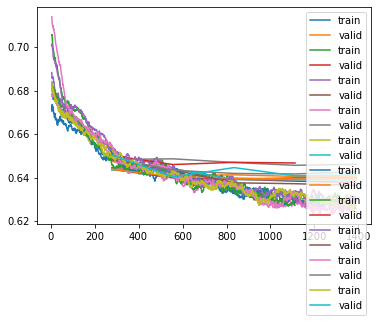

In [8]:
import gc


for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(monitor='petfinder_rmse', fname=f'model_fold{i}', comp=np.less), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()